# lmax vs time

In [71]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

epsilon = 1e-4
lmaxs = np.array([256*n-1 for n in np.arange(1,25)])
blacklist_CPU, blacklist_GPU = [], []

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

runinfos = [
    # ('CPU', 'lenspyx'),
    ('CPU', 'duccnufft'),
    ('GPU', 'cufinufft')    
    ]

blacklist_runinfos = []

popstr_runinfos = [
    ["setup", "gclm2lenmap"],
    ["nuFFT init", "FFTshift"],
    ["Transfers ->", "Transfer <-"],
    # ["dlm2pointing", "spin-1 maps", "pointing"],
    ["rotation", "rotate"]
]
popstr = flatten_extend(popstr_runinfos)

## Check which files exist
fns = '/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backend}_{solver}_{lmax}_e{epsilon}'
for runinfoi, runinfo in enumerate(runinfos):
    _ = []
    for lmax in lmaxs:
        fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
        if not os.path.isfile(fn):
            _.append(lmax)
    blacklist_runinfos.append(_)


data = []
for runinfoi, runinfo in enumerate(runinfos):
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos[runinfoi]:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
            with open(fn, "r") as file:
                _.append(json.load(file))
    data.append(_)

for runinfoi, runinfo in enumerate(runinfos):
    for popstring in popstr:
        for d in data[runinfoi]:
            if popstring in d:
                d.pop(popstring)
# print('---')
              
ress = []
keys = []
for runinfoi, runinfo in enumerate(runinfos):
    data_across_l = {}
    for d in data[runinfoi]:
        keys = d.keys()
        for keyi, key in enumerate(keys):
            if key in data_across_l:
                data_across_l[key].append(d[key])
            else:
                data_across_l[key] = [d[key]]
    _ = np.array([v for k, v in data_across_l.items()])
    ress.append(_)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [72]:
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(lmax_ress[1])

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 4607]


[2303  255 1279 1023 1535 2559 4607 1791  767 2047  511]


/tmp/ipykernel_853587/3441067308.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=35, ha='right')
/tmp/ipykernel_853587/3441067308.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=35, ha='right')


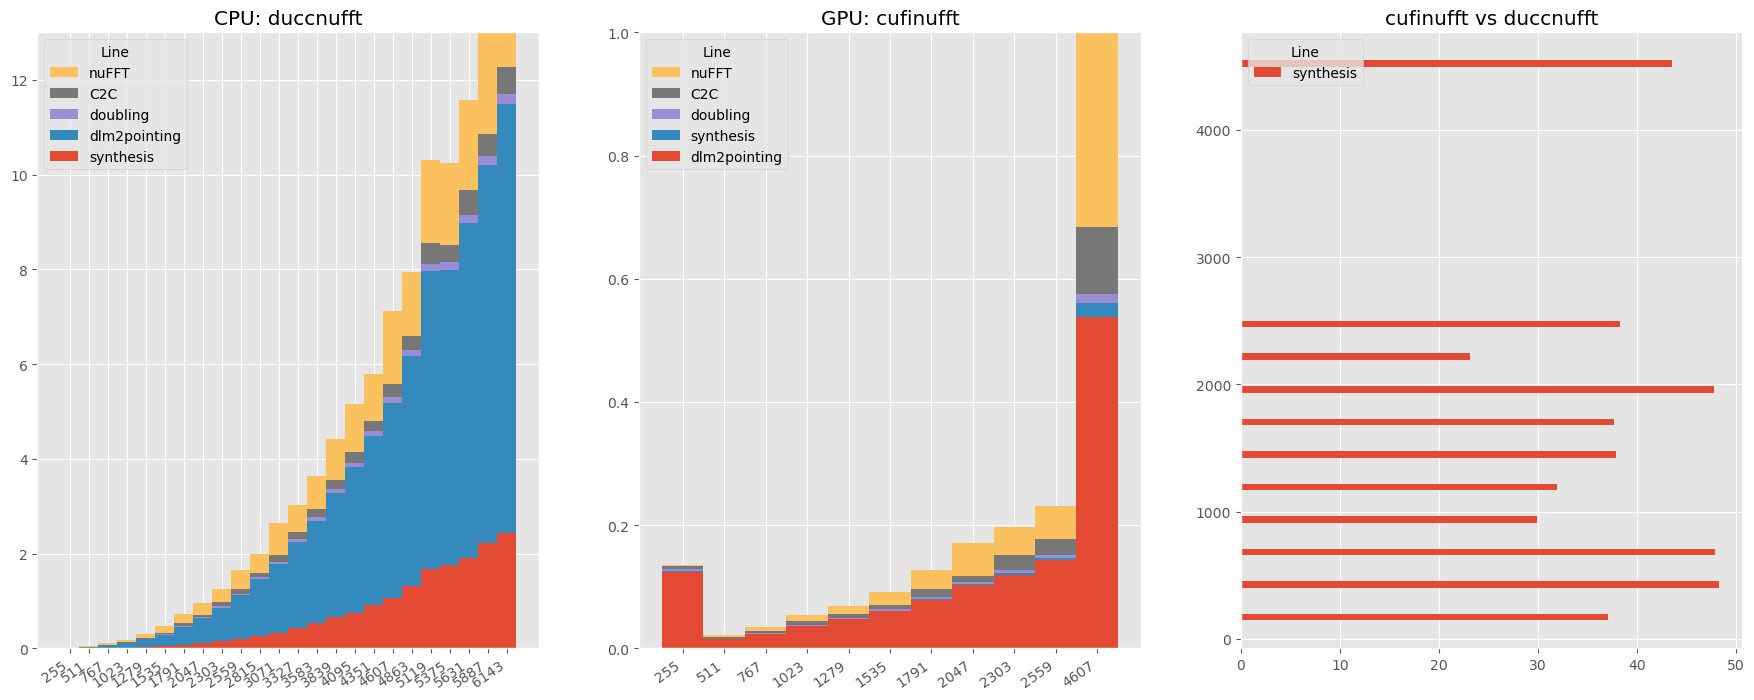

In [73]:
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res):
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 13.0)
ax[1].set_ylim(0.0, 1.0)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=35, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=35, ha='right')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//3
lmax_intersecs = np.array(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]]))))
print(lmax_intersecs)

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]][[1,]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
    # bottom += row1[mask12]/row2[mask21]
ax[2].legend()
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 4607] 11


/tmp/ipykernel_853587/842390797.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([-0.5,-0.4,-0.2,0.,2,4])


Text(0, 0.5, 'Multipole $\\ell$')

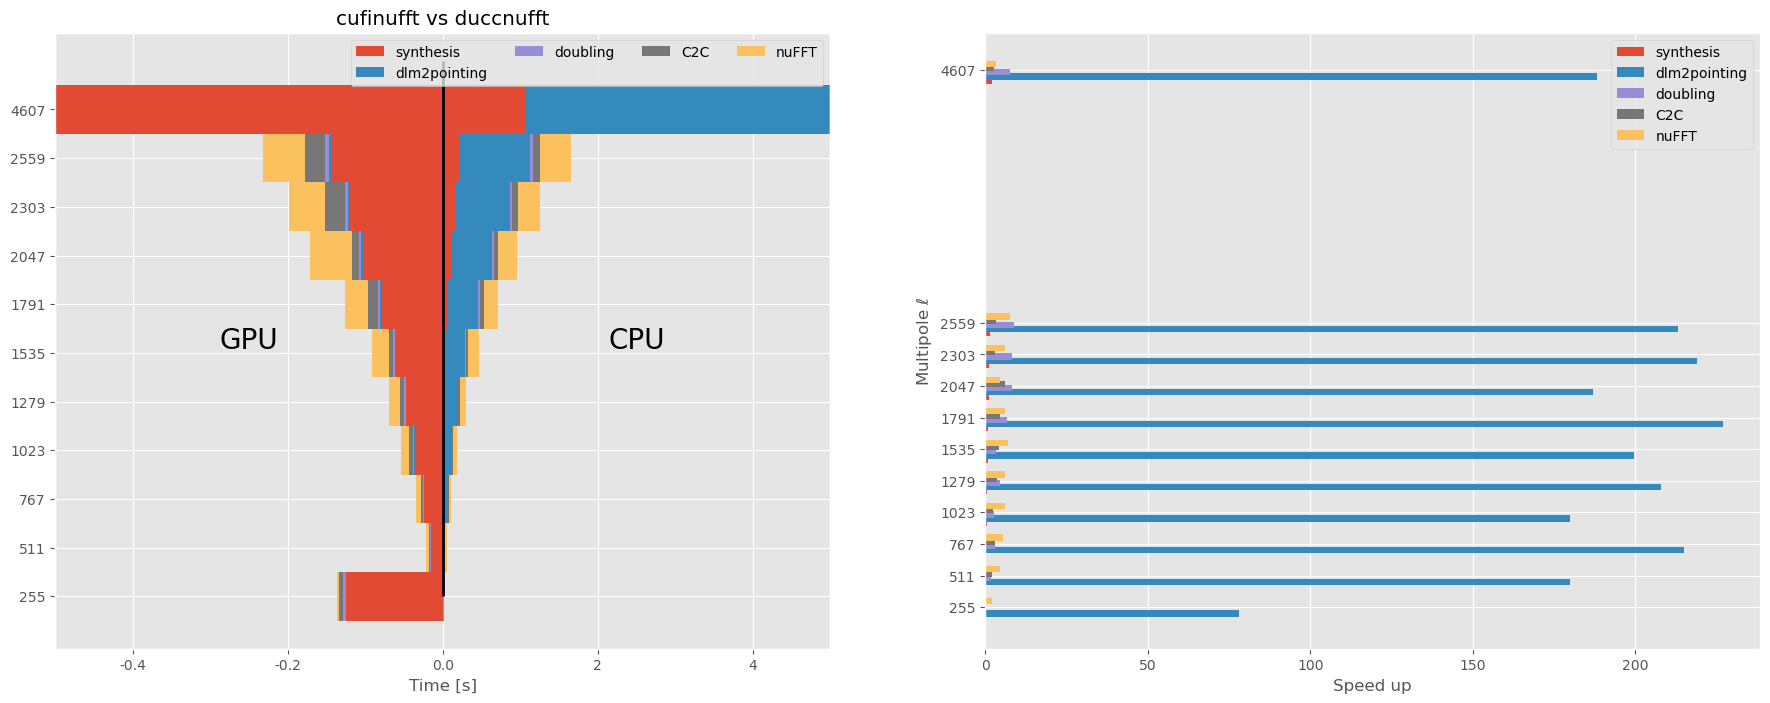

In [74]:
fig, ax = plt.subplots(1,len(runinfos), figsize=(22,8), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

axt = ax[0].twiny()
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi])
    bottom -= row
    axt.set_xlim(-0.5, 0.5)
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, row in enumerate(ress[0]): #[:-1,:]
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom)
    bottom += row[mask12]
    ax[0].set_xlim(-5, 5)
    
    
ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU', horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])
ax[0].set_xticklabels([-0.5,-0.4,-0.2,0.,2,4])

compis = [0,1]
width = np.diff(lmax_ress[compis[0]])[0]//3

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        ress[compis[0]], ress[compis[1]])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()
ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(lmax_intersecs)
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[1].set_ylabel(r'Multipole $\ell$')

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

0 2 [0.07540916 1.27821025 1.78982783 2.00382687 2.53855684 2.84251916
 2.96354253 3.08186095 5.35134289 4.08786619]


/tmp/ipykernel_853587/882843659.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
/tmp/ipykernel_853587/882843659.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')


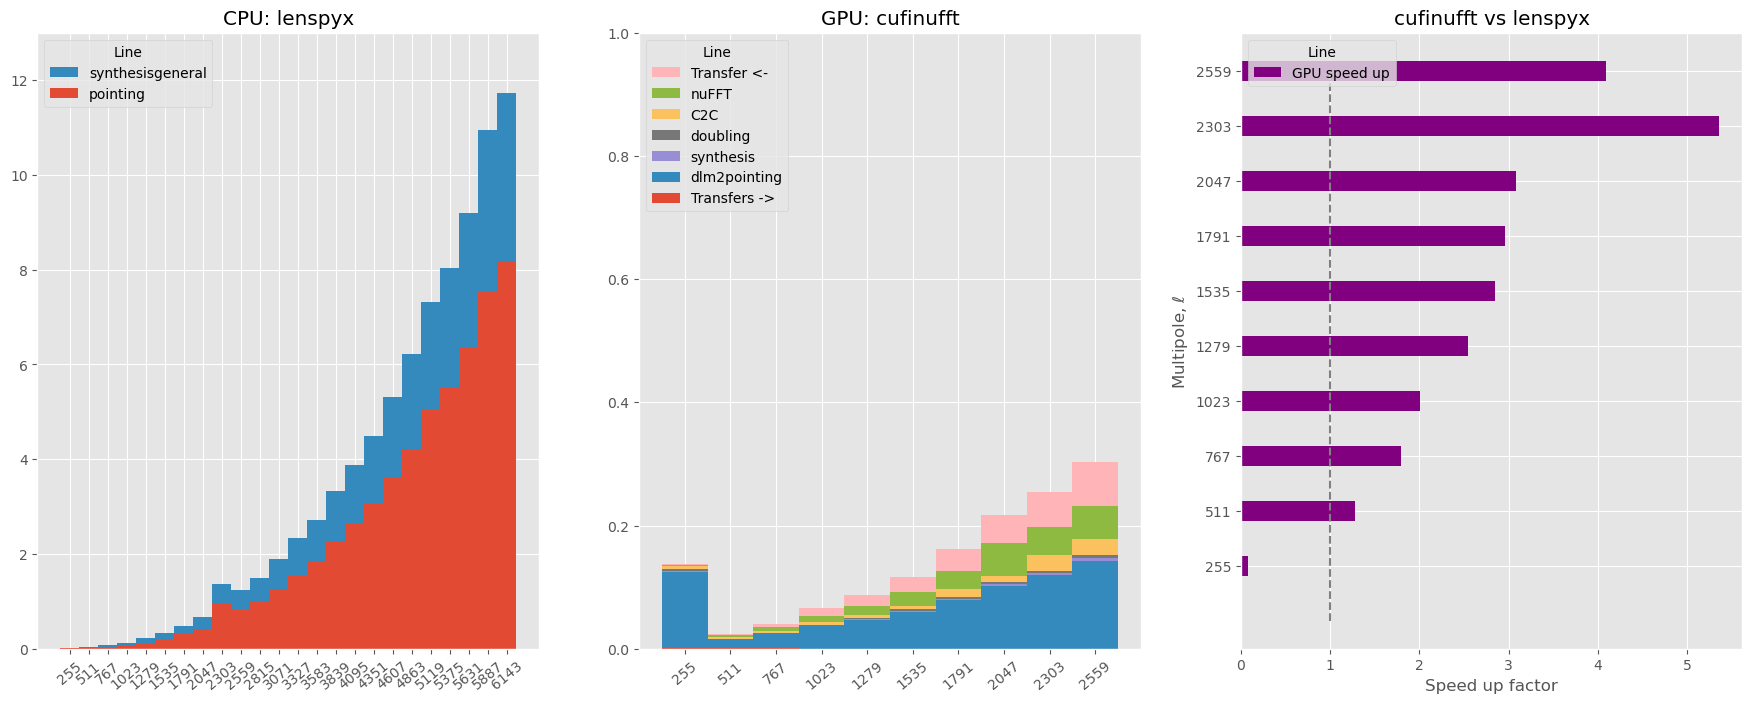

In [53]:
# For comparison with lenspyx, must sum over all rows
fig, ax = plt.subplots(1,len(runinfos)+1,figsize=(22,8), sharey=False)
for resi, res in enumerate(ress):
    bottom = np.zeros(shape=(len(lmax_ress[resi])))
    keys = data[resi][0].keys()
    for rowi, row in enumerate(res): #[:-1,:]
        # if rowi == 0:
            # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')
        ax[resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
        bottom += row
    ax[resi].legend()
    ax[resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
    
    handles, labels = ax[resi].get_legend_handles_labels()
    ax[resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax[0].set_ylim(0.0, 13.0)
ax[1].set_ylim(0.0, 1.0)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha='center')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//4
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    print(rowi, len(keys), row1[mask12]/row2[mask21])
    ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label="GPU speed up", color='purple')
    # bottom += row1[mask12]/row2[mask21]
ax[2].vlines(1,0,np.max(lmax_intersecs), color='grey', ls='--')
ax[2].legend()
ax[2].set_ylabel(r"Multipole, $\ell$")
ax[2].set_xlabel("Speed up factor")
ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[2].set_yticks(lmax_intersecs)
ax[2].set_yticklabels(lmax_intersecs)
# ax[resi].set_ylim(0.0, 1.5)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

[ 255  511  767 1023 1279 1535 1791 2047 2303 2559 3071 3327 3839 4095] 14
[0.01257372 0.03602242 0.0779717  0.14046335 0.23407602 0.35894656
 0.52177596 0.72385263 0.94427943 1.22700095 1.91363025 2.37733841
 3.43877625 4.06221175] [0.11684394 0.02390742 0.0386126  0.06282139 0.09341979 0.12140703
 0.16649771 0.19987059 0.265239   0.30755901 0.54747438 0.56530166
 0.79500246 0.9931767 ]


/tmp/ipykernel_853587/2159183203.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([1.0,0.67,0.33,0.,2,4])


Text(0, 0.5, 'Multipole $\\ell$')

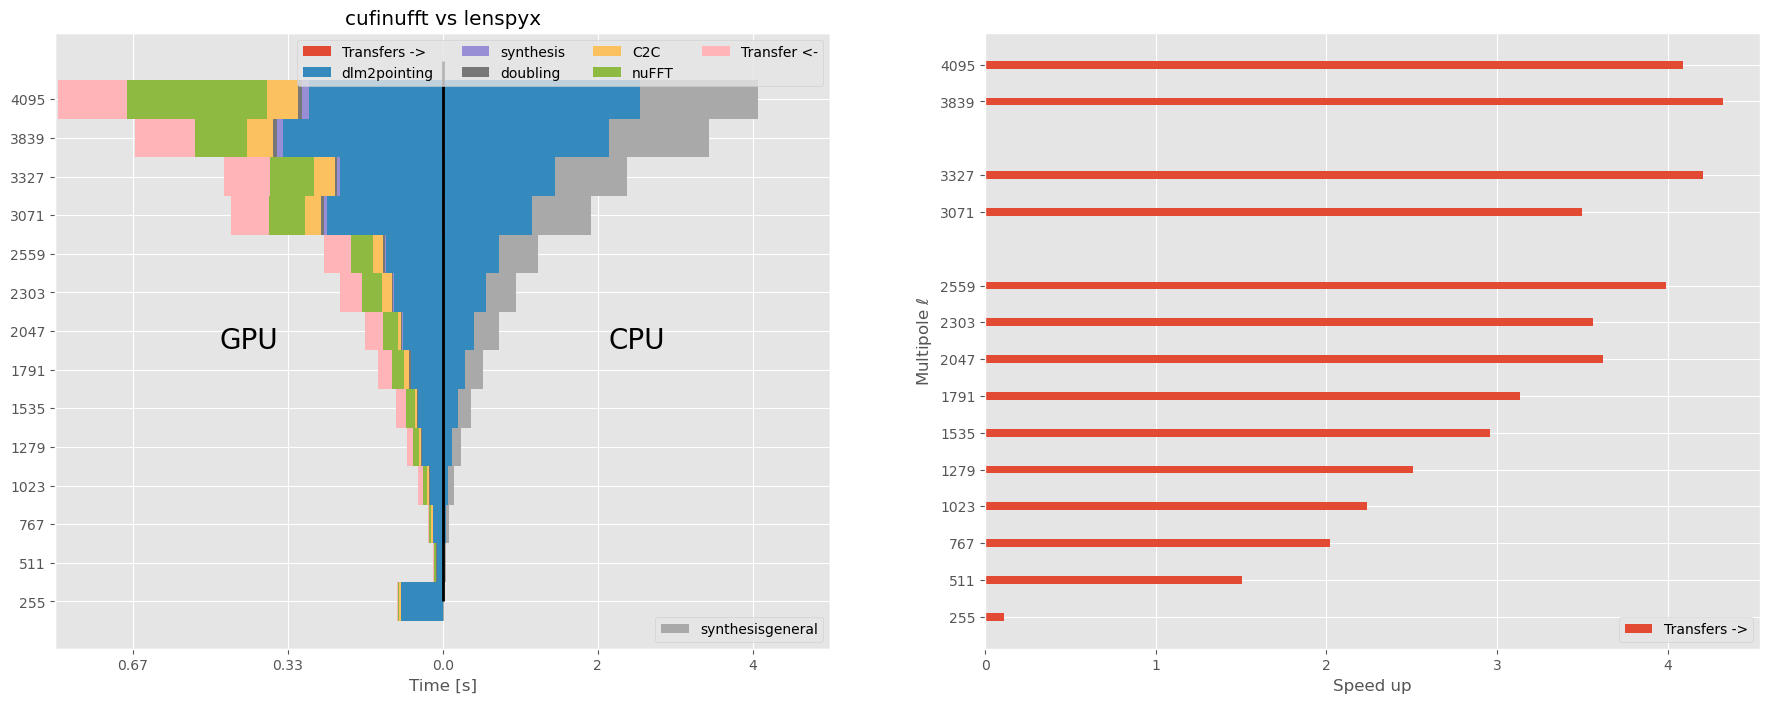

In [46]:
fig, ax = plt.subplots(1,len(runinfos), figsize=(22,8), sharey=False)
lmax_intersecs = np.array(sorted(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]])))))
print(lmax_intersecs, len(lmax_intersecs))

keys = data[1][0].keys()
axt = ax[0].twiny()
bottom = np.zeros(shape=(len(lmax_intersecs)))
for rowi, row in enumerate(ress[1]): #[:-1,:]
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    axt.barh(lmax_intersecs.astype(str), -row[mask21], 1, align='center', left=bottom, label=list(keys)[rowi])
    bottom -= row
    axt.set_xlim(-1.0, 1.0)
    
bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[0][0].keys()
colors = [None, 'darkgrey']
for rowi, row in enumerate(ress[0]):
    ax[0].bar([0,0], [0,0], 1, align='center', bottom=[0,0], label='_')
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mod = '_' if rowi == 0 else ""
    ax[0].barh(lmax_intersecs.astype(str), row[mask12], 1, align='center', left=bottom, color=colors[rowi], label=mod+list(keys)[rowi])
    bottom += row[mask12]
    ax[0].set_xlim(-5, 5)     
ax[0].legend(ncol=1, loc='lower right')
    
    
ax[0].text(0.75, 0.5, 'CPU', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[0].text(0.25, 0.5, 'GPU', horizontalalignment='center', verticalalignment='center', transform=axt.transAxes, fontsize=20)
        
axt.legend(ncol=4)
axt.vlines(0,0,len(lmax_intersecs), color='black', lw=2)
axt.set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
ax[0].set_xlabel('Time [s]')
axt.set_ylabel(r'Multipole $\ell$')
axt.set_xticks([])
ax[0].set_xticklabels([1.0,0.67,0.33,0.,2,4])

compis = [0,1]
width = np.diff(lmax_ress[compis[0]])[0]//2

bottom = np.zeros(shape=(len(lmax_intersecs)))
keys = data[1][0].keys()
for rowi, (row1, row2) in enumerate(
    zip(
        [np.sum(ress[compis[0]],axis=0)], [np.sum(ress[compis[1]],axis=0)])):
    mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
    mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
    offset = -width + rowi/len(keys)*2*width
    offset = 0
    print(row1[mask12], row2)
    ax[1].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi], color='purple')
    # bottom += row1[mask12]/row2[mask21]
ax[1].legend()
ax[1].set_yticks(lmax_intersecs)
ax[1].set_yticklabels(lmax_intersecs)
# ax[1].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
ax[1].set_xlabel('Speed up')
ax[1].set_ylabel(r'Multipole $\ell$')

# ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

# accuracy vs time

In [354]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')
print(mpl.style.available)

epsilons = [1e-6, 1e-10]
lmaxs = np.array([256*n-1 for n in np.arange(1,25)])
blacklist_CPU, blacklist_GPU = [], []

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

runinfos = [
    # ('CPU', 'lenspyx'),
    ('CPU', 'duccnufft'),
    ('GPU', 'cufinufft')    
    ]

blacklist_runinfos = []

popstr_runinfos = [
    ["setup", "gclm2lenmap"],
    ["nuFFT init", "FFTshift"],
    ["Transfers ->", "Transfer <-"],
    ["dlm2pointing", "spin-1 maps", "pointing"],
    ["rotation", "rotate"]
]
popstr = flatten_extend(popstr_runinfos)
fns = '/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backend}_{solver}_{lmax}_e{epsilon}'

for epsiloni, epsilon in enumerate(epsilons):
    for runinfoi, runinfo in enumerate(runinfos):
        _ = []
        for lmax in lmaxs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon)
            if not os.path.isfile(fn):
                _.append(lmax)
        blacklist_runinfos.append(_)

data = []
for epsiloni, epsilon in enumerate(epsilons):
    __ = []
    for runinfoi, runinfo in enumerate(runinfos):
        _ = []
        for lmax in lmaxs:
            if lmax not in blacklist_runinfos[runinfoi]:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], epsilon=epsilon, lmax=lmax)
                with open(fn, "r") as file:
                    _.append(json.load(file))
        __.append(_)
    data.append(__)

for epsiloni, epsilon in enumerate(epsilons):
    for runinfoi, runinfo in enumerate(runinfos):
        for popstring in popstr:
            for d in data[epsiloni][runinfoi]:
                if popstring in d:
                    d.pop(popstring)
              
ress = []
keys = []
for epsiloni, epsilon in enumerate(epsilons):
    __ = []
    for runinfoi, runinfo in enumerate(runinfos):
        data_across_l = {}
        for d in data[epsiloni][runinfoi]:
            keys = d.keys()
            for keyi, key in enumerate(keys):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:
                    data_across_l[key] = [d[key]]
        _ = np.array([v for k, v in data_across_l.items()])
        __.append(_)
    ress.append(__)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [363]:
lmax_ress = []
for blacklist_runinfoi, blacklist_runinfo in enumerate(blacklist_runinfos):
    lmax_ress.append(np.array([l for l in lmaxs if l not in blacklist_runinfo]))
print(len(lmax_ress[1]))

14


/tmp/ipykernel_787161/991355510.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[epsiloni,0].set_xticklabels(ax[epsiloni,0].get_xticklabels(), rotation=35, ha='right')
/tmp/ipykernel_787161/991355510.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[epsiloni,1].set_xticklabels(ax[epsiloni,1].get_xticklabels(), rotation=35, ha='right')


[2303  255 1279 1023 3071  511 1535 2559 4095 1791 3839  767 2047 3327]


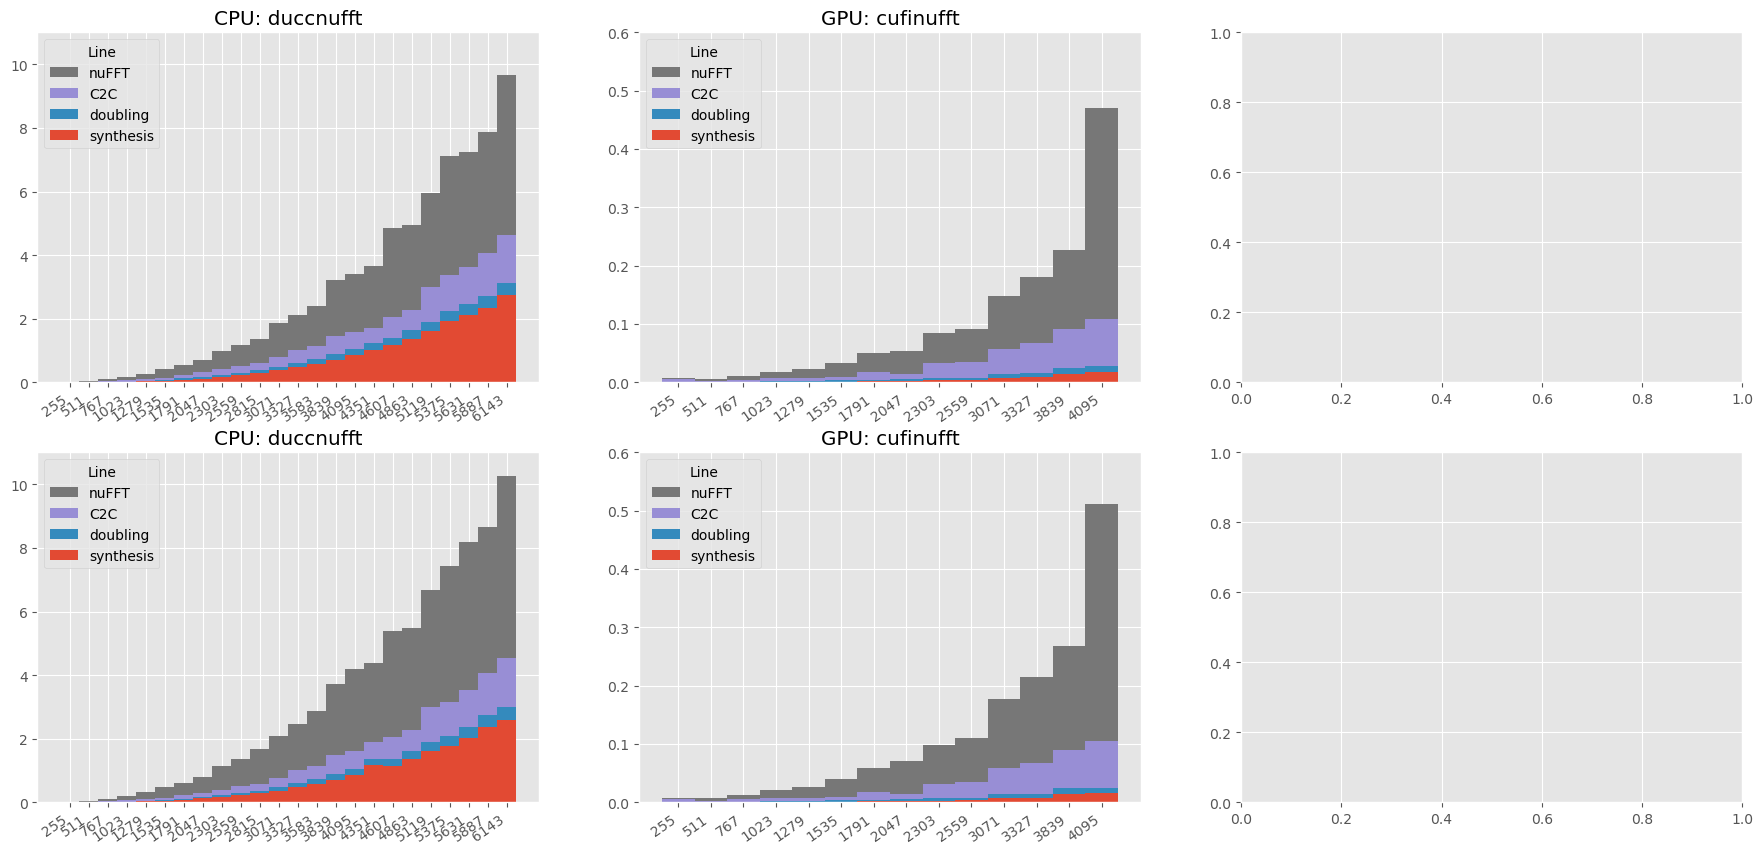

In [376]:
fig, ax = plt.subplots(len(epsilons),len(runinfos)+1,figsize=(22,10), sharey=False)
for epsiloni, epsilon in enumerate(epsilons):
    for resi, res in enumerate(ress[epsiloni]):
        bottom = np.zeros(shape=(len(lmax_ress[resi])))
        keys = data[epsiloni][resi][0].keys()
        for rowi, row in enumerate(res):
            ax[epsiloni,resi].bar(lmax_ress[resi].astype(str), row, 1, align='center', bottom=bottom, label=list(keys)[rowi])
            bottom += row
        ax[epsiloni,resi].legend()
        ax[epsiloni,resi].set_title("{}: {}".format(runinfos[resi][0], runinfos[resi][1]))
        
        handles, labels = ax[epsiloni,resi].get_legend_handles_labels()
        ax[epsiloni,resi].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
    ax[epsiloni,0].set_ylim(0.0, 11.0)
    ax[epsiloni,1].set_ylim(0.0, 0.6)
    ax[epsiloni,0].set_xticklabels(ax[epsiloni,0].get_xticklabels(), rotation=35, ha='right')
    ax[epsiloni,1].set_xticklabels(ax[epsiloni,1].get_xticklabels(), rotation=35, ha='right')

compis = [0,1]
lmax_unions = []
width = np.diff(lmax_ress[compis[0]])[0]//3
lmax_intersecs = np.array(list(
    set(lmax_ress[compis[0]]).intersection(set(lmax_ress[compis[1]]))))
print(lmax_intersecs)

# bottom = np.zeros(shape=(len(lmax_intersecs)))
# keys = data[][0].keys()
# for rowi, (row1, row2) in enumerate(
#     zip(
#         ress[compis[0]], ress[compis[1]])):
#     mask12 = np.isin(lmax_ress[compis[0]], lmax_ress[compis[1]])
#     mask21 = np.isin(lmax_ress[compis[1]], lmax_ress[compis[0]])
#     offset = -width + rowi/len(keys)*2*width
#     ax[2].barh((lmax_intersecs+offset), row1[mask12]/row2[mask21], 3*width/len(keys), align='center', label=list(keys)[rowi])
#     # bottom += row1[mask12]/row2[mask21]
# ax[2].legend()
# ax[2].set_title("{} vs {}".format(runinfos[1][1], runinfos[0][1]))
# # ax[resi].set_ylim(0.0, 1.5)
# handles, labels = ax[2].get_legend_handles_labels()
# ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')